In [31]:
import os
import numpy as np
from matplotlib import pyplot as plt
import datajoint as dj
import h5py
import sys
import pandas as pd
import shutil
import pickle
import jaxley as jx

from djimaging.user.alpha.utils import database
from djimaging.user.alpha.schemas.alpha_schema import *


# Set these to change what cell you want
date = "2020-08-29"
stimulus = "noise_1500"
exp_num = "1"
cell_id = date + "_" + exp_num
field_stim_extract = "d1"  # Assume stimuli are all the same with each ROI


# Get the current working directory
cwd = os.getcwd()

# Get the username
username = os.popen('whoami').read().strip()

# Get the home directory
home_directory = os.path.expanduser("~")
print(username, home_directory)

# Set the path to the data directory where results will be stored
base_dir = f'{home_directory}/GitRepos/jaxley_rgc/deistler_our_data_and_morph'
assert os.path.exists(base_dir), f'{base_dir} does not exist.'


  

ssuhai /gpfs01/euler/User/ssuhai


# RF recentering 

In [32]:
file1 = h5py.File('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/data/SMP_C1_d2_Dnoise.h5', 'r')
noise_stimulus1 = file1["NoiseArray3D"][()]
file2 = h5py.File('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/data/noise.h5', 'r')
noise_stimulus2 = file2["NoiseArray3D"][()]



In [33]:
# load the labels
base_dir=f'{home_directory}/GitRepos/jaxley_rgc/deistler_our_data_and_morph'
with open('/gpfs01/euler/User/ssuhai/GitRepos/jaxley_rgc/deistler_our_data_and_morph/results/data/labels_lowpass_2020-08-29_1.pkl','rb') as handle:
    labels = pickle.load(handle)

In [34]:
def get_rf_from_weighted_image_average(labels,noise_img,rec_id,roi_id,start_idx,stop_idx):
    ca = np.array(labels.loc[(labels['rec_id']==rec_id) & (labels['roi_id']==roi_id)]['ca'].values[0])
    ca = np.array(ca)
    
    weighted_image = noise_img[:,:,start_idx:stop_idx] * ca[np.newaxis,np.newaxis,start_idx:stop_idx] 
    rf = np.mean(weighted_image,axis=2)

    return rf



In [35]:
def get_image_locs(df,uncorrected=False):
    pixel_size = 30
    if uncorrected:
        image_center_x = df["image_center_x_uncorrected"].item()
        image_center_y = df["image_center_y_uncorrected"].item()
    else:
        image_center_x = df["image_center_x"].item()
        image_center_y = df["image_center_y"].item()
    im_pos_x = np.linspace(-7.5*pixel_size + 0.5, 7.5*pixel_size - 0.5, 15*pixel_size) + image_center_x
    im_pos_y = -np.linspace(-10.0*pixel_size + 0.5, 10.0*pixel_size - 0.5, 20*pixel_size) + image_center_y
    return im_pos_x, im_pos_y

/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/utils/misc_utils.py:97: UserWarning: nseg is deprecated and will be removed in version 0.6.0.
  warnings.warn(msg + self._amend_msg)
/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(
/gpfs01/euler/User/ssuhai/GitRepos/jaxley/jaxley/io/swc.py:63: UserWarning: Found a segment with length 0. Clipping it to 1.0
  warn("Found a segment with length 0. Clipping it to 1.0")


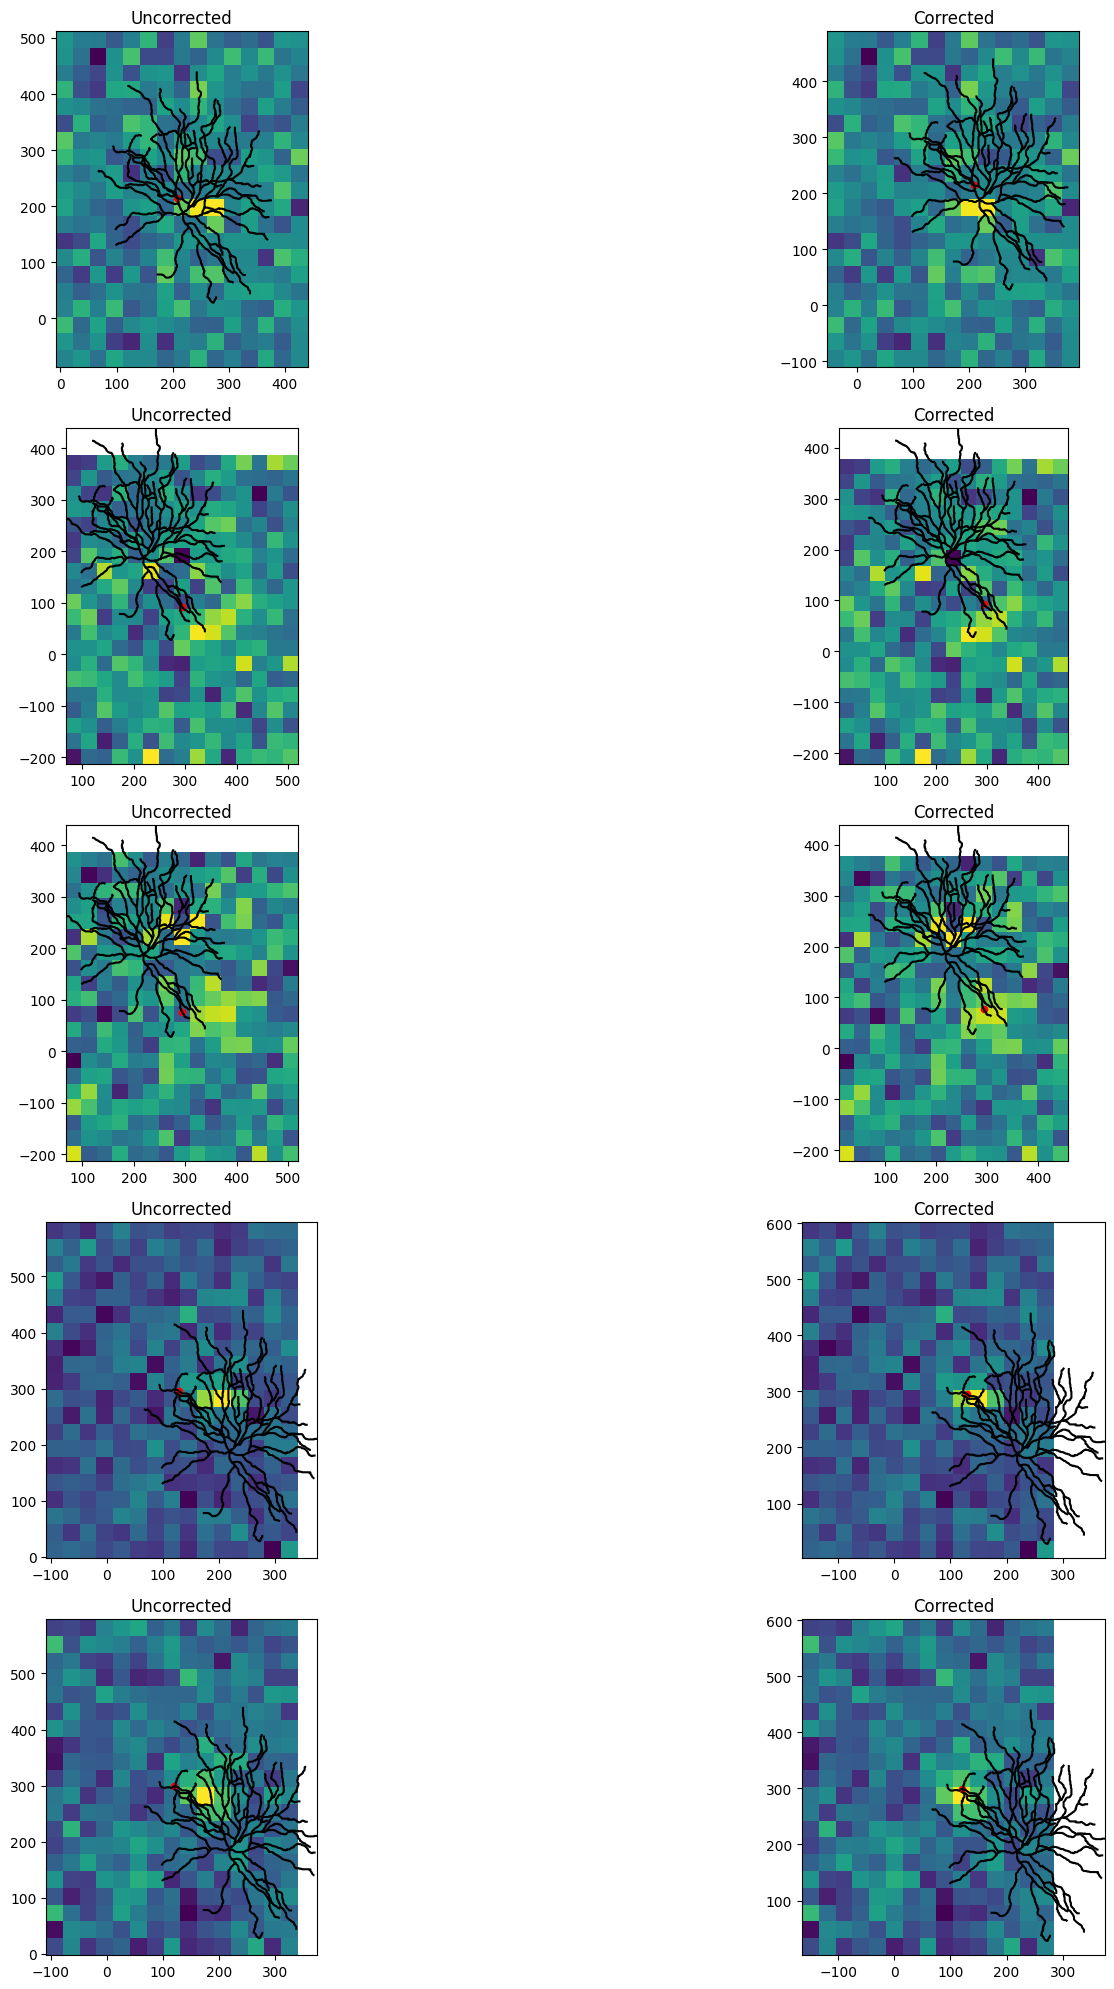

In [36]:
all_dfs = pd.read_pickle(f"{base_dir}/results/data/setup.pkl")
cell = jx.read_swc(f"{base_dir}/morphologies/{cell_id}.swc", nseg=4, max_branch_len=300.0, min_radius=5.0)

def plot_rf_on_morphology(cell,all_df,rec_id,roi_id,cell_id,labels, noise_stimulus,ax,uncorrected=False):
    ax.autoscale(enable=True, axis='both', tight=True) # Add this line
   
    ax.set_aspect('equal', adjustable='box') # Or 'auto' if needed


    df = all_dfs[all_dfs["cell_id"] == cell_id]
    df = df[df["rec_id"] == rec_id]
    df = df[df["roi_id"] == roi_id]

    im_pos_x, im_pos_y = get_image_locs(df,uncorrected=uncorrected)

    cell.vis(ax=ax)

    rf = get_rf_from_weighted_image_average(labels, noise_stimulus, rec_id, roi_id, start_idx=100, stop_idx=1000)

    
    # show rf
    im = ax.imshow(rf.T, extent=[im_pos_x[0], im_pos_x[-1], im_pos_y[-1], im_pos_y[0]])
    _ = ax.scatter(
        df["roi_x"],
        df["roi_y"],
        s=20,
        c="red"
    )
    #plt.colorbar(im, ax=ax) # Add this line to create the colorbar. The 'im' argument links it to the image.

    
recs = [0,1,1,2,2]
rois = [3,5,3,2,4]

fig, axes = plt.subplots(len(recs),2,figsize=(20,20))
axes = axes.flatten()
for idx,(rec_id, roi_id) in enumerate(zip(recs,rois)):
    ax = axes[idx*2]
    plot_rf_on_morphology(cell,all_dfs,rec_id=rec_id,roi_id=roi_id,cell_id=cell_id,labels=labels, noise_stimulus=noise_stimulus1,ax=ax,uncorrected=True)
    ax.set_title(f"Uncorrected")

    ax = axes[idx*2 + 1]    
    plot_rf_on_morphology(cell,all_dfs,rec_id=rec_id,roi_id=roi_id,cell_id=cell_id,labels=labels, noise_stimulus=noise_stimulus1,ax=ax,uncorrected=False)
    ax.set_title(f"Corrected")

plt.savefig(
    f"{base_dir}/report_figs/correction_effects_rf_on_morphology_{cell_id}.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.tight_layout()
plt.show()


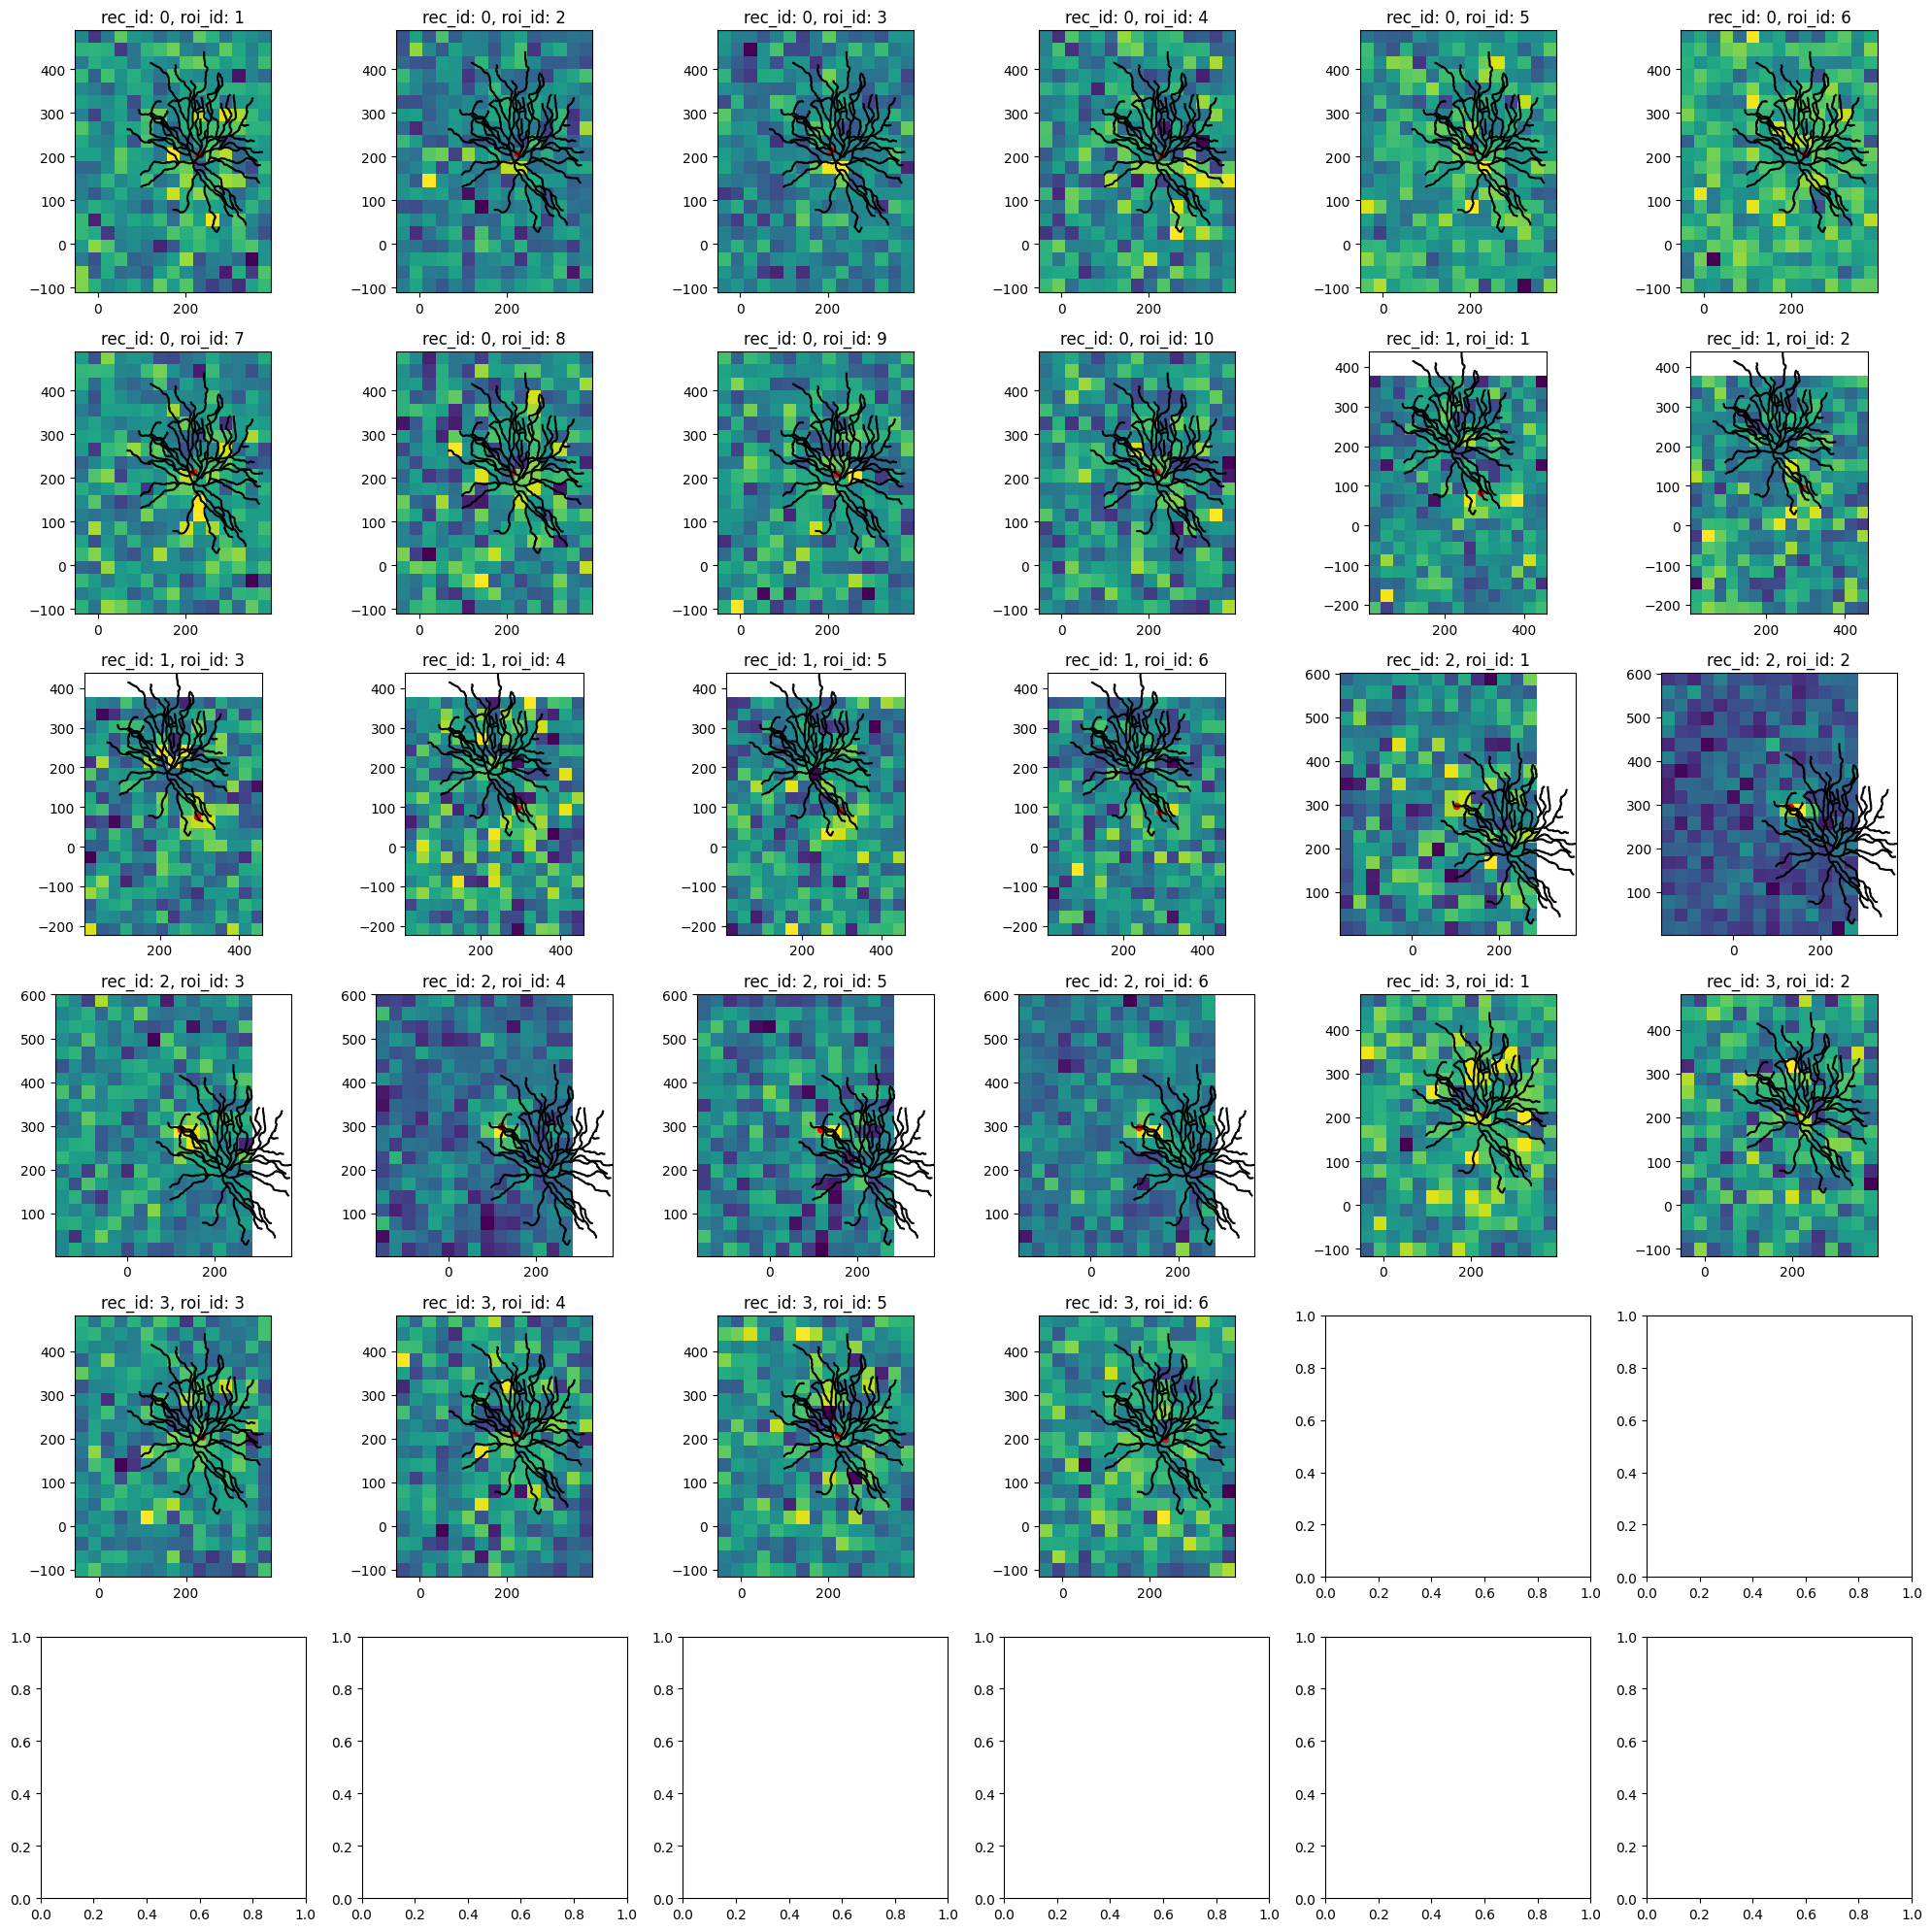

In [44]:
import itertools
n_rois = len(labels)
n_rows_plot = int(np.ceil(np.sqrt(n_rois)))
fig, ax = plt.subplots(n_rows_plot,n_rows_plot, figsize=(20, 20))

ax = itertools.chain(ax.flatten())
for rec_id in range(0, 4):
    max_roi = np.max(labels.loc[labels['rec_id'] == rec_id]['roi_id'].values)
    for roi_id in range(1, max_roi + 1):
        rf = get_rf_from_weighted_image_average(labels, noise_stimulus1, rec_id, roi_id, start_idx=100, stop_idx=1000)
        
        ax_i = next(ax)
        plot_rf_on_morphology(cell,all_dfs,
                              rec_id=rec_id,
                              roi_id=roi_id,
                              cell_id=cell_id,
                              labels=labels, 
                              noise_stimulus=noise_stimulus1,
                              ax=ax_i,
                              uncorrected=False)
        ax_i.set_title(f'rec_id: {rec_id}, roi_id: {roi_id}')
plt.tight_layout()
plt.show()


# quality index of rois

In [38]:
# Set config file
config_file = f'{home_directory}/datajoint/dj_{username}_conf.json'
assert os.path.isfile(config_file), f'Set the path to your config file: {config_file}'

# Path to djimaging
path_to_djimaging = f'{home_directory}/GitRepos/s-on-alpha-regional/code/AlphaDjimaging/djimaging'

# Set schema name
schema_name = 'ageuler_joesterle_alpha_ca'
indicator = 'calcium'
database.connect_dj(indicator=indicator)

[2025-02-19 17:56:28,442][WARNING]: MySQL server has gone away. Reconnecting to the server.


schema_name: ageuler_joesterle_alpha_ca
dataset: calcium


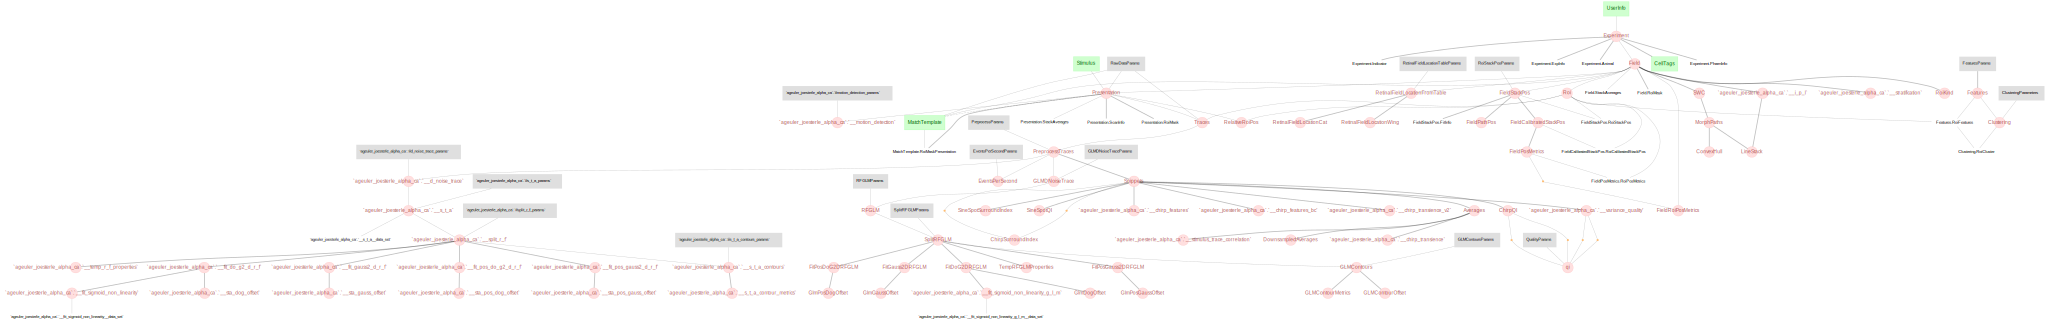

In [39]:
dj.ERD(database)

In [40]:
database.get_roi_tab(quality_filter=True) & f'date="2020-08-29"' & 'field!="d4"'

experimenter name of the experimenter,date date of recording,exp_num experiment number in a day,field string identifying files corresponding to field,roi_id integer id of each ROI,roi_size number of pixels in ROI,roi_size_um2 size of ROI in micrometers squared,"roi_dia_um diameter of ROI in micrometers, if it was a circle",artifact_flag flag if roi contains light artifact (1) or not (0)
Ran,2020-08-29,1,d1,1,29,9.04879,3.3943,0
Ran,2020-08-29,1,d1,2,16,4.99244,2.52122,0
Ran,2020-08-29,1,d1,3,9,2.80825,1.89092,0
Ran,2020-08-29,1,d1,4,17,5.30446,2.59882,0
Ran,2020-08-29,1,d1,5,12,3.74433,2.18344,0
Ran,2020-08-29,1,d1,6,9,2.80825,1.89092,0
Ran,2020-08-29,1,d1,7,14,4.36838,2.35839,0
Ran,2020-08-29,1,d1,8,10,3.12027,1.9932,0
Ran,2020-08-29,1,d1,9,8,2.49622,1.78277,0
Ran,2020-08-29,1,d1,10,9,2.80825,1.89092,0


In [41]:
database.QualityIndex() &

SyntaxError: invalid syntax (2216573051.py, line 1)